# Master's Thesis Experiments Report

In [15]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from scripts.utils import load_latency_data, load_frame_size_data, clean_latency_data

In [16]:
# constants
FIG_DIR = './figures/{}'

## 1.   Pipeline Latency
The data was replayed at 8 Mbps.
For each frame f, we measure the timedelta between the last emitted LiDAR data packet and
the last incoming Palicus data packet containing data associated with f.
We exclude the first and the last frame to ensure that we only consider the latency of full frames.

In [17]:
fig_dir = FIG_DIR.format('latency')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [18]:
# Load the data
df_conversion = load_latency_data(pipeline='conversion')
df_roi = load_latency_data(pipeline='roi')
df_dm1 = load_latency_data(pipeline='dm1')
df_dm2 = load_latency_data(pipeline='dm2')
df_bev = load_latency_data(pipeline='bev')
df_max = load_latency_data(pipeline='max')

In [19]:
# tabular representation
l = 'latency [ms]'

results = [['min', df_conversion.min()[l], df_roi.min()[l], df_dm1.min()[l], df_dm2.min()[l], df_bev.min()[l],
            df_max.min()[l]],
           ['mean', df_conversion.mean()[l], df_roi.mean()[l], df_dm1.mean()[l], df_dm2.mean()[l], df_bev.mean()[l],
            df_max.mean()[l]],
           ['median', df_conversion.median()[l], df_roi.median()[l], df_dm1.median()[l], df_dm2.median()[l],
            df_bev.median()[l], df_max.median()[l]],
           ['max', df_conversion.max()[l], df_roi.max()[l], df_dm1.max()[l], df_dm2.max()[l], df_bev.max()[l],
            df_max.max()[l]]
           ]

df_latency_results = pd.DataFrame(results, columns=['', 'CONV', 'RoI', 'DM (1)', 'DM (2)', 'BEV', 'MAX'])
print(df_latency_results)


              CONV       RoI    DM (1)    DM (2)        BEV        MAX
0     min  0.19040  0.186200  0.185200  0.193200   0.294200   0.297800
1    mean  0.38236  0.387328  0.388334  0.389076  46.049722  46.049746
2  median  0.30000  0.299800  0.300800  0.301400  47.708600  47.709400
3     max  1.56920  1.606200  1.563400  1.576000  47.823800  47.828400


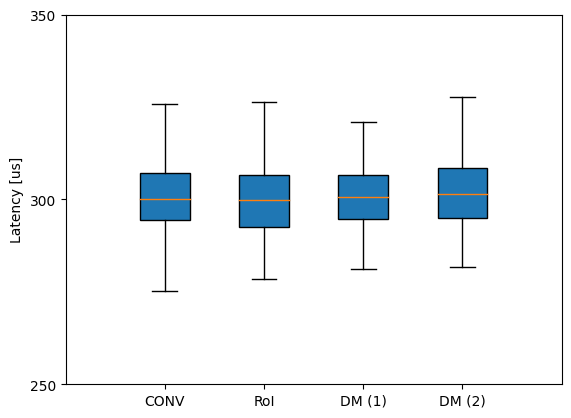

In [20]:
# computation time: conversion vs. RoI vs. DepthMap
df_conversion['CONV'] = df_conversion['latency [ms]'] * 1000
df_roi['RoI'] = df_roi['latency [ms]'] * 1000
df_dm1['DM (1)'] = df_dm1['latency [ms]'] * 1000
df_dm2['DM (2)'] = df_dm2['latency [ms]'] * 1000

fig, ax = plt.subplots()
ax.boxplot(df_conversion['CONV'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['CONV'])
ax.boxplot(df_roi['RoI'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['RoI'])
ax.boxplot(df_dm1['DM (1)'].to_numpy(), positions=[6], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (1)'])
ax.boxplot(df_dm2['DM (2)'].to_numpy(), positions=[8], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (2)'])
ax.set(xlim=(0, 10))
ax.set(ylim=(250, 350), yticks=[250 + i * 50 for i in range(3)], ylabel='Latency [us]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'conv_roi_dm.png'))

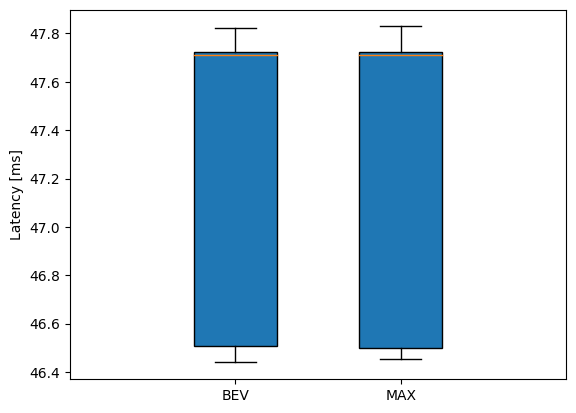

In [21]:
# computation time: BEV vs. MAX
fig, ax = plt.subplots()
ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['BEV'])
ax.boxplot(df_max['latency [ms]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['MAX'])
ax.set(xlim=(0, 6))
ax.set(ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'bev_max.png'))

### Latency Impact of PEs

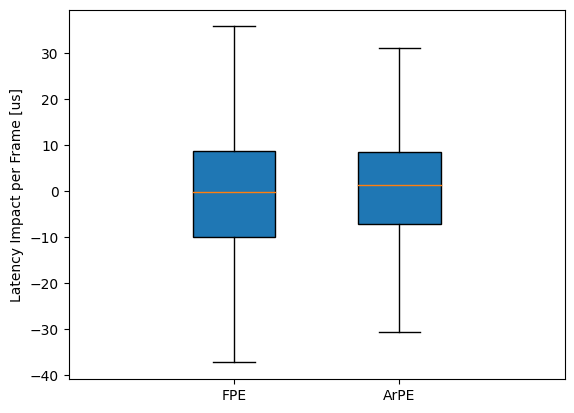

In [22]:
# FPE
df_compare_fpe = pd.concat([df_conversion.loc[:, 'CONV'],
                            df_roi.loc[:, 'RoI']], axis=1)
df_compare_fpe['diff'] = df_compare_fpe['RoI'] - df_compare_fpe['CONV']

# ArPE
df_compare_1 = pd.concat([df_roi.loc[:, 'RoI'],
                          df_dm1.loc[:, 'DM (1)']], axis=1)
df_compare_1['diff'] = df_compare_1['DM (1)'] - df_compare_1['RoI']
df_compare_1 = df_compare_1.loc[:, 'diff']

df_compare_2 = pd.concat([df_dm1.loc[:, 'DM (1)'],
                          df_dm2.loc[:, 'DM (2)']], axis=1)
df_compare_2['diff'] = df_compare_2['DM (2)'] - df_compare_2['DM (1)']
df_compare_2 = df_compare_2.loc[:, 'diff']

df_compare_arpe = pd.DataFrame(pd.concat([df_compare_1, df_compare_2.rename('diff')], axis=0))

fig, ax = plt.subplots()
ax.boxplot(df_compare_fpe['diff'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['FPE'])
ax.boxplot(df_compare_arpe['diff'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['ArPE'])
ax.set(xlim=(0, 6))
ax.set(ylabel='Latency Impact per Frame [us]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'fpe_arpe_impact.png'))

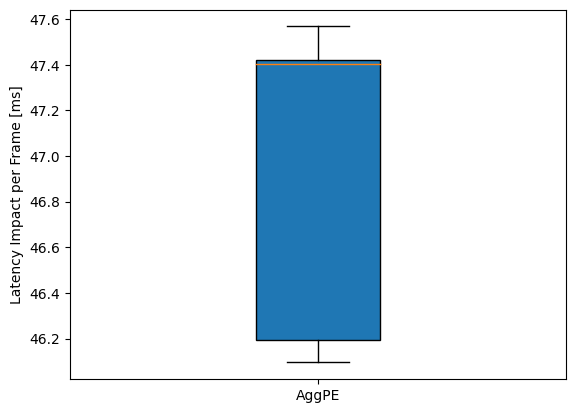

In [23]:
# AggPE
df_compare_aggpe = pd.concat([df_dm2.loc[:, 'latency [ms]'].rename('DM'),
                              df_bev.loc[:, 'latency [ms]'].rename('BEV')], axis=1)
df_compare_aggpe['diff'] = df_compare_aggpe['BEV'] - df_compare_aggpe['DM']

fig, ax = plt.subplots()
ax.boxplot(df_compare_aggpe['diff'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['AggPE'])
ax.set(xlim=(0, 4))
ax.set(ylabel='Latency Impact per Frame [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'aggpe_impact.png'))

In [24]:
# crop sample to [mean - 2*sd, mean + 2*sd]
df_compare_fpe = clean_latency_data(df_compare_fpe, col='diff', factor=1)
df_compare_arpe = clean_latency_data(df_compare_arpe, col='diff', factor=1)
df_compare_aggpe = clean_latency_data(df_compare_aggpe, col='diff', factor=1)

res_table = [['Span', '[{},{}]'.format(str(round(df_compare_fpe.min()['diff'], 3)), str(round(df_compare_fpe.max()['diff'], 3))),
              '[{},{}]'.format(str(round(df_compare_arpe.min()['diff'], 3)), str(round(df_compare_arpe.max()['diff'], 3))),
              '[{},{}]'.format(str(round(df_compare_aggpe.min()['diff'], 3)), str(round(df_compare_aggpe.max()['diff'], 3)))],
             ['Mean', df_compare_fpe.mean()['diff'], df_compare_arpe.mean()['diff'], df_compare_aggpe.mean()['diff']],
             ['Median', df_compare_fpe.median()['diff'], df_compare_arpe.median()['diff'],
              df_compare_aggpe.median()['diff']]
             ]

df_res = pd.DataFrame(res_table, columns=['', 'FPE [us]', 'ArPE [us]', 'AggPE [ms]'])
print(df_res)


                 FPE [us]     ArPE [us]       AggPE [ms]
0    Span  [-127.6,111.0]  [-16.2,18.0]  [46.095,47.568]
1    Mean       -1.937864      0.928341        47.002889
2  Median            -0.2           1.3          47.4027


#### Impact of FPE on Frame Size

In [25]:
# Conversion
# conv_packets = load_packet_data(throughput='8Mbps', pipeline='conversion')
# conv_packets = pd.DataFrame(conv_packets.groupby('frame_nr').count()['pkt_nr'])

# RoI
# roi_packets = load_packet_data(throughput='8Mbps', pipeline='roi')
# roi_packets = pd.DataFrame(roi_packets.groupby('frame_nr').count()['pkt_nr'])

# f_compare_pkt = pd.concat([conv_packets.loc[:, 'pkt_nr'].rename('CONV'),
#                            roi_packets.loc[:, 'pkt_nr'].rename('RoI')], axis=1)
# df_compare_pkt['ratio'] = df_compare_pkt['RoI'] / df_compare_pkt['CONV'] * 100

# print('mean\t', df_compare_pkt.mean()['ratio'])
# print('median\t', df_compare_pkt.median()['ratio'])


## 2. Point Rate

In [31]:
# Conversion
total_elem = []
cols = ['Pipeline', '8Mbps', '16Mbps', '32Mbps', '64Mbps', '128Mbps']
for p in ['conversion', 'roi', 'dm1', 'dm2', 'bev', 'max']:
    log = [p]
    for t in [8, 16, 32, 64, 128]:
        df = load_frame_size_data(pipeline=p)
        total = df.loc[df['throughput'] == t]
        total = total.loc[total['frame_nr'] == 'TOTAL', 'n_elements'].values[0]
        # print(total)
        log.append(total)
    total_elem.append(log)

df_res = pd.DataFrame(total_elem, columns=cols)

print(df_res)

     Pipeline     8Mbps    16Mbps    32Mbps    64Mbps   128Mbps
0  conversion  30458448  30459216  30459216  30459216  30458832
1         roi  29103848  29103848  29103848  29103848  29101546
2         dm1  29103848  29103080  29103848  29101935  29095025
3         dm2  29103848  29103848  29102696  29103848  29098102
4         bev    139468    139468    139468    139468    139450
5         max    139468    139468    139468    139468    139468
